# Google Drive mounting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports and constants

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
KEYWORD = "Sztandar 1930"
# ROOT_PATH = "./"
ROOT_PATH = "/content/drive/MyDrive/coin-wear-estimator"

import sys
sys.path.append(ROOT_PATH+'/dataset')
sys.path.append(ROOT_PATH+'/normalisation')
from utils import get_filename

NIEMCZYK_SET_PATH = "{}/dataset/niemczyk/img/{}".format(ROOT_PATH, get_filename(KEYWORD))
MARCINIAK_SET_PATH = "{}/dataset/marciniak/img/{}".format(ROOT_PATH, get_filename(KEYWORD))

In [4]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import itertools
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
import numpy as np
from coin_detector import crop_coin
import pandas as pd
from utils import get_filename
from PIL import Image
import os
import pandas as pd
from tqdm.notebook import tqdm
from IPython.display import clear_output
import seaborn as sns

In [6]:
%whos

Variable             Type        Data/Info
------------------------------------------
Image                module      <module 'PIL.Image' from <...>t-packages/PIL/Image.py'>
KEYWORD              str         Sztandar 1930
MARCINIAK_SET_PATH   str         /content/drive/MyDrive/co<...>rciniak/img/sztandar_1930
NIEMCZYK_SET_PATH    str         /content/drive/MyDrive/co<...>iemczyk/img/sztandar_1930
ROOT_PATH            str         /content/drive/MyDrive/coin-wear-estimator
clear_output         function    <function clear_output at 0x7f7774f53d40>
crop_coin            function    <function crop_coin at 0x7f77365ee320>
cv2                  module      <module 'cv2.cv2' from '/<...>37m-x86_64-linux-gnu.so'>
drive                module      <module 'google.colab.dri<...>s/google/colab/drive.py'>
ellipse_perimeter    function    <function ellipse_perimeter at 0x7f773ec84ef0>
get_filename         function    <function get_filename at 0x7f775166ef80>
hough_ellipse        function    <function h

# Data exploration

In [27]:
def calculate_sizes(root):
    names = [name for name in os.listdir(root) if name.split(".")[-1] == "jpg"]
    df = pd.DataFrame({"name": names, "size": None})

    pbar = tqdm(total=len(df))
    for i, row in df.iterrows():
      row["size"] = Image.open(root + "/" + row["name"]).size[0]
      pbar.update(1)
    df.to_csv(root + "/data.csv", index=None)
    pbar.close()

calculate_sizes(NIEMCZYK_SET_PATH + "/aligned")
calculate_sizes(MARCINIAK_SET_PATH + "/aligned")

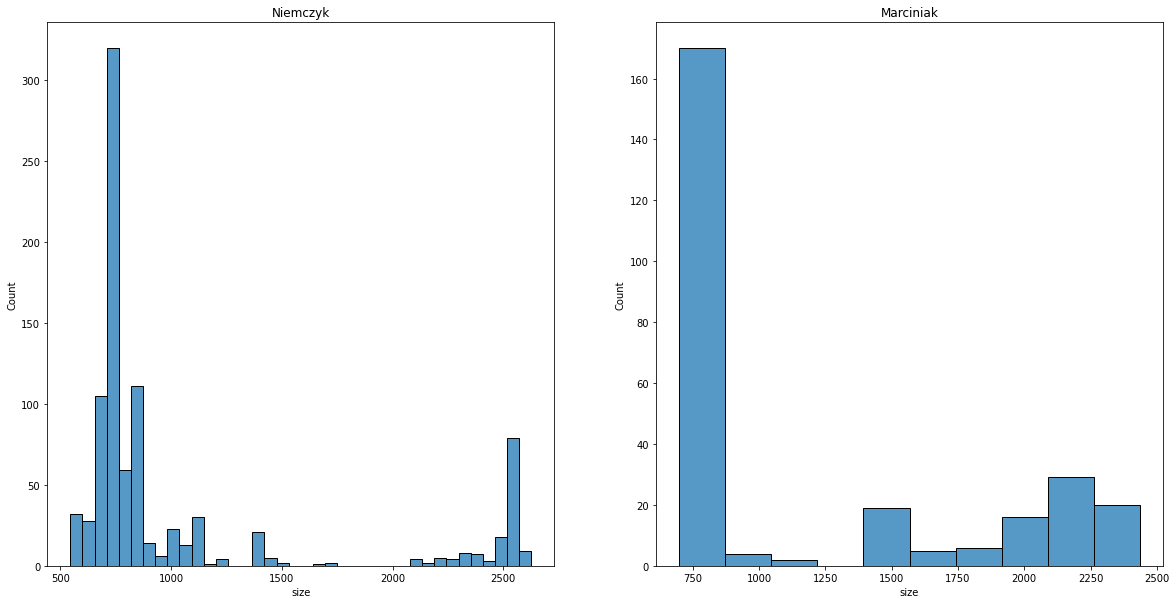

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

for i, ds_path in enumerate([NIEMCZYK_SET_PATH, MARCINIAK_SET_PATH]):
  path_dir = ds_path + "/aligned"
  df = pd.read_csv(path_dir + "/data.csv")
  sns.histplot(df["size"], ax=ax[i])

ax[0].set_title("Niemczyk")
ax[1].set_title("Marciniak")
plt.show()


# Master coin

In [7]:
def generate_master_coin(root, label):
  df1 = pd.read_csv(root + "/aligned/data.csv")
  df2 = pd.read_csv(root + "/labels.csv")
  df = df1.merge(df2, how='inner', on='name')
  df = df.sort_values(by=['size'], ascending=False)
  df = df[df["label"] == label]
  names = df["name"]
  
  stack = np.stack([cv2.resize(cv2.imread(root + "/aligned/" + name), (700,700)) for name in names[:100]])
  master_coin = np.uint8(np.mean(stack, axis=0))

  return master_coin

master_coin_1_n = generate_master_coin(NIEMCZYK_SET_PATH, 1)
cv2.imwrite(NIEMCZYK_SET_PATH + "/master_coin/1.jpg", master_coin_1_n)
master_coin_2_n = generate_master_coin(NIEMCZYK_SET_PATH, 2)
cv2.imwrite(NIEMCZYK_SET_PATH + "/master_coin/2.jpg", master_coin_2_n)
master_coin_1_m = generate_master_coin(MARCINIAK_SET_PATH, 1)
cv2.imwrite(MARCINIAK_SET_PATH + "/master_coin/1.jpg", master_coin_1_m)
master_coin_2_m = generate_master_coin(MARCINIAK_SET_PATH, 2)
cv2.imwrite(MARCINIAK_SET_PATH + "/master_coin/2.jpg", master_coin_2_m);

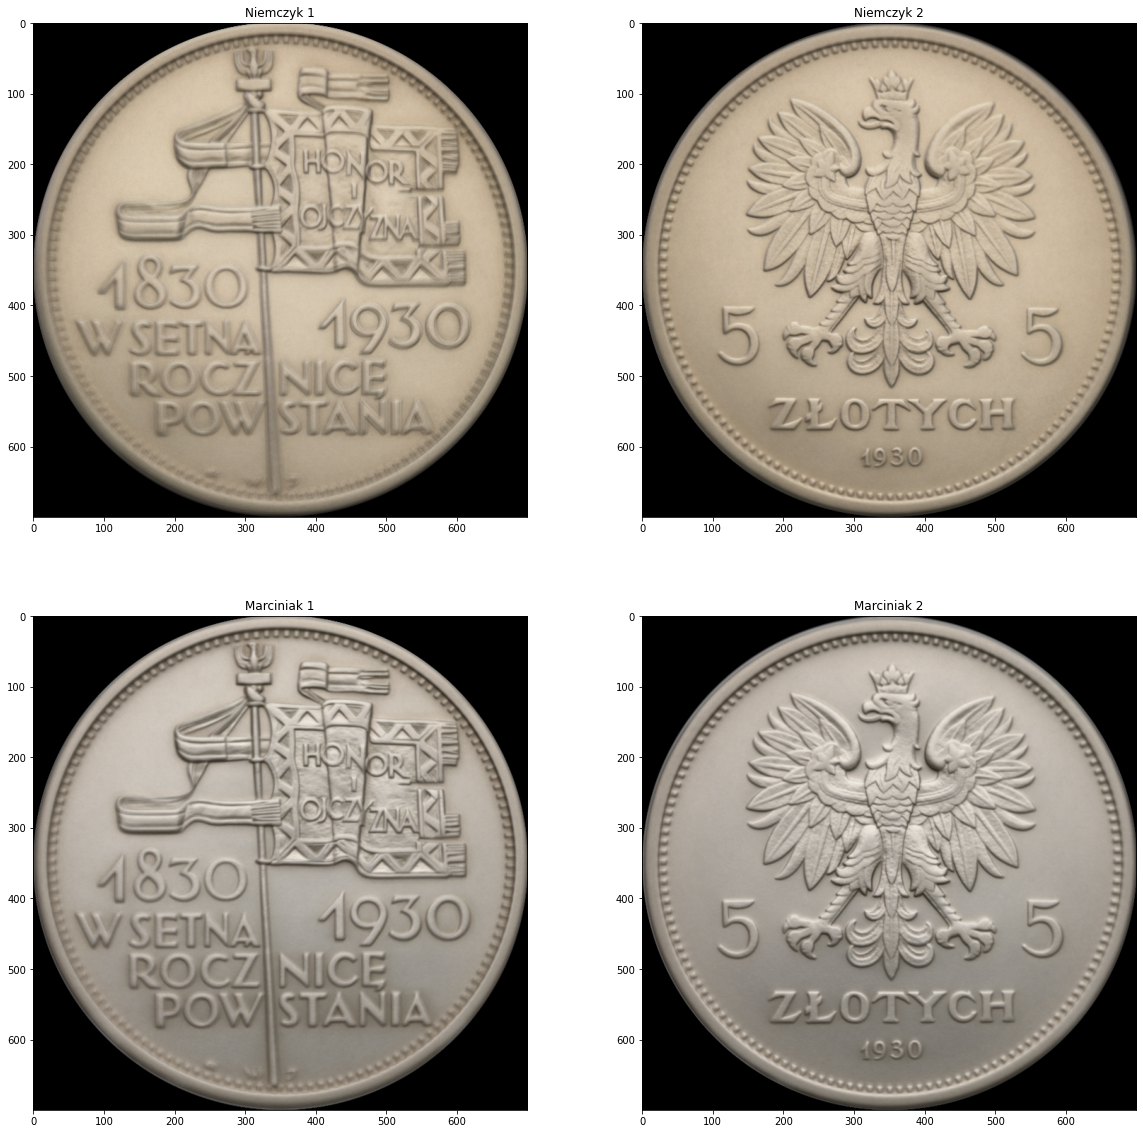

In [20]:
fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2,2, figsize=(20,20))
ax1.imshow(cv2.cvtColor(master_coin_1_n, cv2.COLOR_BGR2RGB))
ax2.imshow(cv2.cvtColor(master_coin_2_n, cv2.COLOR_BGR2RGB))
ax3.imshow(cv2.cvtColor(master_coin_1_m, cv2.COLOR_BGR2RGB))
ax4.imshow(cv2.cvtColor(master_coin_2_m, cv2.COLOR_BGR2RGB))

ax1.set_title("Niemczyk 1")
ax2.set_title("Niemczyk 2")
ax3.set_title("Marciniak 1")
ax4.set_title("Marciniak 2")

plt.show()

True

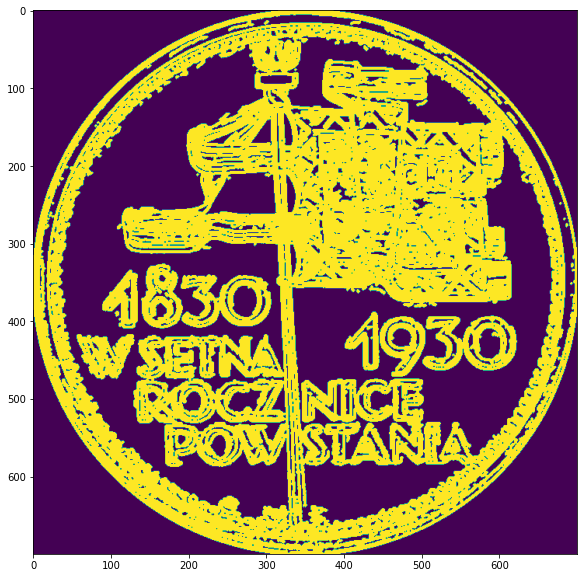

In [87]:
  im = cv2.cvtColor(master_coin_1_m, cv2.COLOR_BGR2GRAY)
  im = cv2.Canny(im, 0.1*255, 0.2*255)
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
  im = cv2.morphologyEx(im, cv2.MORPH_CLOSE, kernel)
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4,4))
  im = cv2.dilate(im, kernel ,iterations = 1)
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
  im = cv2.morphologyEx(im, cv2.MORPH_OPEN, kernel)
  
  plt.figure(figsize=(10,10))
  plt.imshow(im)

255

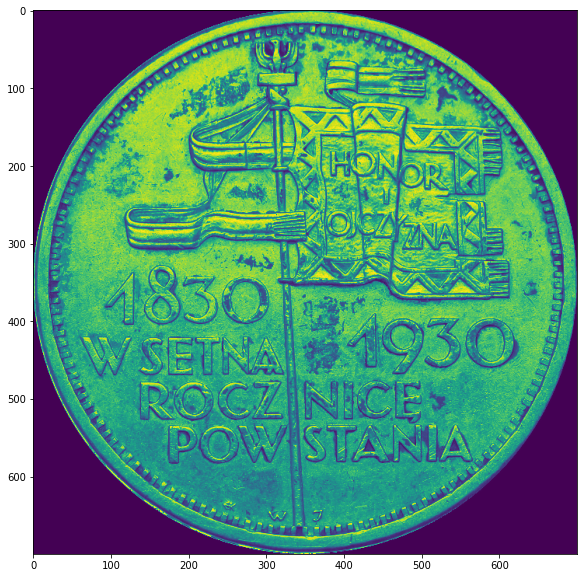

In [91]:
test_im = cv2.imread(MARCINIAK_SET_PATH + '/aligned/1_1.jpg')
test_im = cv2.cvtColor(test_im, cv2.COLOR_BGR2GRAY)
test_im = cv2.resize(test_im, (700,700))
# test_im = cv2.Canny(test_im, 0.6*255, 0.8*255)
test_im = test_im - im

plt.figure(figsize=(10,10))
plt.imshow(test_im)